In [1]:

import torch
import os
import matplotlib.pyplot as plt

from torchvision.io import read_image, write_png
from torch.utils.cpp_extension import load_inline
from pathlib import Path
from PIL import Image

In [2]:
torch.__version__

'2.0.1+cu117'

In [3]:
DEVICE = "cuda:0"
ROOT_DIR = os.path.abspath("..")
IMAGES_DIR = Path(ROOT_DIR) / "images"
BUILD_DIR = Path(ROOT_DIR) / "build"
BUILD_DIR.mkdir(exist_ok=True)
KERNELS_DIR = Path(ROOT_DIR) / "kernels_torch"
IMAGES_DIR


PosixPath('/media/nvme/vs_code/cuda_torch_learning/pmpp/images')

In [4]:
%matplotlib inline
def show_image(image, title=None):
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    # plt.show()

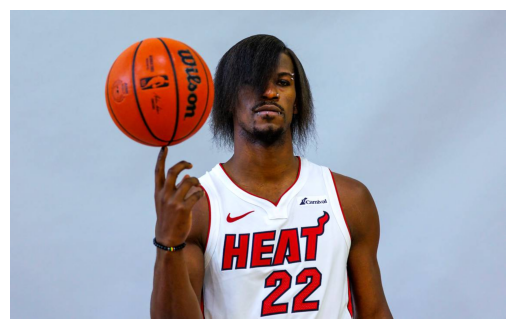

In [5]:
test_image = read_image(str(IMAGES_DIR / "jimmy.jpeg")).to(DEVICE).contiguous()
# resize image
# test_image = torch.nn.functional.interpolate(test_image[None], 
#                                              (256, 256), 
#                                              mode="bilinear", 
#                                              align_corners=False)[0]
show_image(test_image.cpu().numpy().transpose(1, 2, 0))

### Image Blur

In [130]:
cuda_source = (KERNELS_DIR / "imageBlur.cu").read_text()
cpp_source = "torch::Tensor blur_filter(torch::Tensor image, int radius);"
image_blur_module = load_inline(
    name="image_blur",
    cpp_sources=[cpp_source],
    cuda_sources=[cuda_source],
    functions=["blur_filter"],
    build_directory=BUILD_DIR,
    verbose=True,
)

The input conditions for extension module image_blur have changed. Bumping to version 9 and re-building as image_blur_v9...
Detected CUDA files, patching ldflags
Emitting ninja build file /media/nvme/vs_code/cuda_torch_learning/pmpp/build/build.ninja...
Building extension module image_blur_v9...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=image_blur_v9 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/TH -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /media/nvme/vs_code/cuda_torch_learning/pmpp/build/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=image_blur_v9 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc

Loading extension module image_blur_v9...


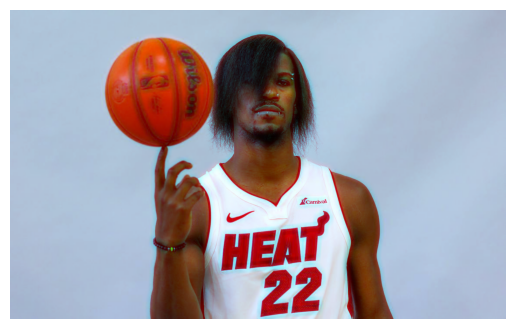

In [141]:
test_blured_image = image_blur_module.blur_filter(test_image, 11)
show_image(test_blured_image.cpu().numpy().transpose(1, 2, 0))

### Dummy threads 

In [22]:
cuda_source = (KERNELS_DIR / "checkThreadIdxs.cu").read_text()
cpp_source = "torch::Tensor check_thread_idxs(torch::Tensor input);"
cuda_test_module = load_inline(
    name="check_thread_idxs",
    cpp_sources=[cpp_source],
    cuda_sources=[cuda_source],
    functions=["check_thread_idxs"],
    # build_directory=BUILD_DIR,
    verbose=True,
)

Using /home/aleksei/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
The input conditions for extension module check_thread_idxs have changed. Bumping to version 3 and re-building as check_thread_idxs_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/aleksei/.cache/torch_extensions/py310_cu117/check_thread_idxs/build.ninja...
Building extension module check_thread_idxs_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=check_thread_idxs_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/TH -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/aleksei/.cache/torch_extensions/py310_cu117/check_thread_idxs/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=check_thread_idxs_v3 -DTORCH_API_INCLUDE_EXTENSION_H 

Loading extension module check_thread_idxs_v3...


In [31]:
n = 1024 + 51
zero_tensor = torch.ones(n * 3, 
                          device=DEVICE, 
                          dtype=torch.float) * -1
cuda_test_module.check_thread_idxs(zero_tensor)

tensor([256.,   0.,   0.,  ..., 256.,   0.,  50.], device='cuda:0')

In [32]:
zero_tensor = zero_tensor.reshape(n, 3)
print(zero_tensor[:, 0].unique())
print(zero_tensor[:, 1].unique())
print(zero_tensor[:, 2].unique())
# zero_tensor[256:512]

tensor([256.], device='cuda:0')
tensor([0., 1., 2., 3., 4.], device='cuda:0')
tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137.

In [34]:
zero_tensor[256:]

tensor([[256.,   4.,   0.],
        [256.,   4.,   1.],
        [256.,   4.,   2.],
        ...,
        [256.,   0.,  48.],
        [256.,   0.,  49.],
        [256.,   0.,  50.]], device='cuda:0')

### MatMul

In [6]:
cuda_source = (KERNELS_DIR / "matrixMul.cu").read_text()
cpp_source = """
torch::Tensor matmul(const torch::Tensor first, const torch::Tensor second);
torch::Tensor tiled_matmul(const torch::Tensor first, const torch::Tensor second);
"""
matrix_mul_module = load_inline(
    name="matrix_mul",
    cpp_sources=[cpp_source],
    cuda_sources=[cuda_source],
    functions=["matmul", "tiled_matmul"],
    extra_cuda_cflags=['--ptxas-options=-v'],
    # build_directory=BUILD_DIR,
    verbose=True,
)

Using /home/aleksei/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/aleksei/.cache/torch_extensions/py310_cu117/matrix_mul/build.ninja...
Building extension module matrix_mul...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=matrix_mul -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/TH -isystem /home/aleksei/miniconda3/envs/classification-dev2/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/aleksei/miniconda3/envs/classification-dev2/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/aleksei/.cache/torch_extensions/py310_cu117/matrix_mul/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=matrix_mul -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"

Loading extension module matrix_mul...


In [7]:
a = torch.randn(1024, 1024, device=DEVICE)
b = torch.randn(1024, 1024, device=DEVICE)

%timeit a @ b; torch.cuda.synchronize()
%timeit matrix_mul_module.matmul(a, b); torch.cuda.synchronize()
%timeit matrix_mul_module.tiled_matmul(a, b); torch.cuda.synchronize()


gt = a @ b

result = matrix_mul_module.matmul(a, b)
print(f"Max diff: {torch.max(torch.abs(result - gt))}")
result_tiled = matrix_mul_module.tiled_matmul(a, b)
print(f"Max diff: {torch.max(torch.abs(result_tiled - gt))}")
result.shape

258 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.25 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.41 ms ± 2.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Max diff: 0.000274658203125
Max diff: 0.000274658203125


torch.Size([1024, 1024])

In [13]:
num_repeats = 100
with torch.profiler.profile(
    # with_stack=True,
    # profile_memory=True,
    # schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    # with_flops=True,
) as prof:
    for _ in range(num_repeats):
        matrix_mul_module.matmul(a, b)
        torch.cuda.synchronize()
    
    for _ in range(num_repeats):
        matrix_mul_module.tiled_matmul(a, b)
        torch.cuda.synchronize()

    for _ in range(num_repeats):
        a @ b
        torch.cuda.synchronize()

print(prof.key_averages().table())

STAGE:2024-09-05 23:59:09 384755:384755 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


RuntimeError: stack.size() INTERNAL ASSERT FAILED at "../torch/csrc/autograd/profiler_python.cpp":963, please report a bug to PyTorch. Python replay stack is empty.